# Spectral Bias on Manifolds

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from argparse import Namespace
from functools import reduce

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

## Data Generation

The code for generating the dataset and evaluating FFT. 

In [2]:
def make_phased_waves(opt):
    t = np.arange(0, 1, 1./opt.N)
    if opt.A is None:
        yt = reduce(lambda a, b: a + b, 
                    [np.sin(2 * np.pi * ki * t + 2 * np.pi * phi) for ki, phi in zip(opt.K, opt.PHI)])
    else:
        yt = reduce(lambda a, b: a + b, 
                    [Ai * np.sin(2 * np.pi * ki * t + 2 * np.pi * phi) for ki, Ai, phi in zip(opt.K, opt.A, opt.PHI)])
    if opt.CLASSIFICATION: 
        yt = (yt > 0).astype('float32')
    return t, yt

def fft(opt, yt):
    n = len(yt) # length of the signal
    k = np.arange(n)
    T = n/opt.N
    frq = k/T # two sides frequency range
    frq = frq[range(n//2)] # one side frequency range
    # -------------
    FFTYT = np.fft.fft(yt)/n # fft computing and normalization
    FFTYT = FFTYT[range(n//2)]
    fftyt = abs(FFTYT)
    return frq, fftyt

def to_torch_dataset_1d(opt, t, yt):
    t = torch.from_numpy(t).view(-1, 1).float()
    yt = torch.from_numpy(yt).view(-1, 1).float()
    if opt.CUDA:
        t = t.cuda()
        yt = yt.cuda()
    return t, yt

def generate_dataset(opt):
    def R(phi):
        return 1 + 0.5 * np.sin(opt.L * phi)
    phis = np.arange(0, 2 * np.pi, 2 * np.pi/opt.N)
    xs = R(phis) * np.cos(phis)
    ys = R(phis) * np.sin(phis)
    _, z = make_phased_waves(opt)
    if opt.CLASSIFICATION:
        z = (z > 0).astype('float32')
    return xs, ys, z

def to_torch_dataset_2d(opt, xs, ys, z):
    xy = np.concatenate((xs[:, None], ys[:, None]), axis=1).astype('float32')
    xy = torch.from_numpy(xy)
    z = torch.from_numpy(z[:, None]).float()
    if opt.CUDA: 
        xy = xy.cuda()
        z = z.cuda()
    return xy, z

def generate_meshgrid(opt):
    xx, yy = np.meshgrid(np.linspace(-1.6, 1.6, int(200)),
                         np.linspace(-1.6, 1.6, int(200)))
    return xx, yy

def to_torch_meshgrid(opt, xx, yy):
    xxyy = torch.from_numpy(np.concatenate((xx[..., None], yy[..., None]), 
                                           axis=-1)
                            .reshape(-1, 2)).float()
    if opt.CUDA:
        xxyy = xxyy.cuda()
    return xxyy

## Model Training

In [3]:
def make_model(opt):
    layers = []
    layers.append(nn.Linear(opt.INP_DIM, opt.WIDTH))
    layers.append(nn.ReLU())
    for _ in range(opt.DEPTH - 2): 
        layers.append(nn.Linear(opt.WIDTH, opt.WIDTH))
        layers.append(nn.ReLU())
    layers.extend([nn.Linear(opt.WIDTH, opt.OUT_DIM)])
    model = nn.Sequential(*layers)
    if opt.CUDA:
        model = model.cuda()
    return model

In [4]:
def power_iteration(A, num_simulations=10):
    # Ideally choose a random vector
    # To decrease the chance that our vector
    # Is orthogonal to the eigenvector
    A = A.data
    b_k = A.new(A.shape[1], 1).normal_()
    for _ in range(num_simulations):
        # calculate the matrix-by-vector product Ab
        b_k1 = A @ b_k
        # calculate the norm
        b_k1_norm = torch.norm(b_k1)
        # re normalize the vector
        b_k = b_k1 / b_k1_norm
    return ((b_k.t() @ A @ b_k) / b_k.t() @ b_k).squeeze().abs()
    # return torch.dot(torch.dot(b_k.t(), A), b_k) / torch.dot(b_k.t(), b_k)

def spectral_norm(model): 
    norms = []
    for layer in model: 
        if isinstance(layer, nn.Linear):
            if layer.in_features == layer.out_features: 
                norms.append(power_iteration(layer.weight).cpu().numpy())
            elif layer.in_features == 1 or layer.out_features == 1: 
                norms.append(torch.norm(layer.weight.data))
    return norms

In [37]:
def train_model(opt, model, input_, target):
    # Build loss
    if opt.CLASSIFICATION:
        loss_fn = nn.BCEWithLogitsLoss()
    else:
        loss_fn = nn.MSELoss()
    # Build optim
    optim = torch.optim.Adam(model.parameters(), lr=opt.LR)
    # Rec
    frames = []
    model.train()
    # To cuda
    if opt.CUDA:
        input_ = input_.cuda()
        target = target.cuda()
    # Loop! 
    for iter_num in range(opt.NUM_ITER):
        if iter_num % (opt.NUM_ITER // 100) == 0: 
            print(">", end='')
        x = input_
        yt = target.view(-1, opt.OUT_DIM)
        optim.zero_grad()
        y = model(x)
        loss = loss_fn(y, yt)
        loss.backward()
        optim.step()
        if iter_num % opt.REC_FRQ == 0: 
            # Measure accuracy if required
            if opt.CLASSIFICATION:
                with torch.no_grad():
                    acc = (F.sigmoid(y).data.gt(0.5).float()
                           .eq(yt.data).float().mean().item())
            else:
                acc = 0
            # Measure spectral norm
            frames.append(Namespace(iter_num=iter_num, 
                                    prediction=y.data.cpu().numpy(), 
                                    loss=loss.item(), 
                                    acc=acc,
                                    spectral_norms=spectral_norm(model)))
    # Done
    model.eval()
    return frames

## Visualization

In [6]:
# ---- Set up cmaps ----
cmapd = sns.diverging_palette(250, 10, s=75, l=40, center='dark', as_cmap=True)
cmap = sns.diverging_palette(250, 10, s=75, l=40, center='light', as_cmap=True)
# -----
cmap2 = sns.diverging_palette(145, 280, s=85, l=25, as_cmap=True)
cmap2d = sns.diverging_palette(145, 280, s=85, l=25, center='dark', as_cmap=True)
# -----
cmap3 = sns.diverging_palette(220, 20, as_cmap=True)
cmap3d = sns.diverging_palette(220, 20, center='dark', as_cmap=True)

In [43]:
def plot_wave_and_spectrum(opt, x, yox):
    # Btw, "yox" --> "y of x"
    # Compute fft
    k, yok = fft(opt, yox)
    # Plot
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(9, 4))
    ax0.set_title("Function")
    ax0.plot(x, yox)
    ax0.set_xlabel("x")
    ax0.set_ylabel("f(x)")
    ax1.set_title("FT of Function")
    ax1.plot(k, yok)
    ax1.set_xlabel("k")
    ax1.set_ylabel("f(k)")
    plt.show()
    
def plot_manifold(opt, binarize=False): 
    xs, ys, z = generate_dataset(opt)
    if binarize: 
        z = (z > 0).astype('float32')
    plt.figure(figsize=(5, 5))
    plt.scatter(xs, ys, c=z, cmap=cmap, s=4)
    plt.show()

def plot_model(opt, model):
    xx, yy = generate_meshgrid(opt)
    im_shape = xx.shape
    xxyy = to_torch_meshgrid(opt, xx, yy)
    z = model(xxyy).data.cpu().numpy()
    z = z.reshape(*im_shape)
    # Threshold z
    z_thresh = (z > 0.).astype('float32')
    z_confidence = np.abs(z)
    xy, z_gt = to_torch_dataset_2d(opt, *generate_dataset(opt))
    z_xy = model(xy).data.cpu().numpy()
    xy = xy.cpu().numpy()
    # Plot
    plt.figure(figsize=(6, 6))
    plt.grid(False)
    plt.contourf(xx, yy, z_thresh, 50, cmap=cmap3, alpha=0.1)
    plt.contour(xx, yy, z_confidence, 15, alpha=0.2, 
                cmap=sns.cubehelix_palette(light=0.85, dark=0.03, as_cmap=True))
    plt.scatter(xy[:, 0], xy[:, 1], c=z_gt[:, 0], s=7, cmap=cmap, alpha=0.8)
    plt.show()
    
def plot_history(frames):
    iter_nums = []
    losses = []
    accs = []
    for frame in frames:
        iter_nums.append(frame.iter_num)
        losses.append(frame.loss)
        accs.append(frame.acc)
    plt.figure()
    plt.title("Training Curve")
    plt.plot(iter_nums, losses, label='Loss')
    plt.plot(iter_nums, accs, label='Accuracy')
    plt.legend()
    plt.show()

In [8]:
def compute_spectra(opt, frames): 
    # Make array for heatmap
    dynamics = []
    xticks = []
    for iframe, frame in enumerate(frames): 
        # Compute fft of prediction
        frq, yfft = fft(opt, frame.prediction.squeeze())
        dynamics.append(yfft)
        xticks.append(frame.iter_num)
    return np.array(frq), np.array(dynamics), np.array(xticks)

def plot_spectral_dynamics(opt, all_frames):
    all_dynamics = []
    # Compute spectra for all frames
    for frames in all_frames: 
        frq, dynamics, xticks = compute_spectra(opt, frames)
        all_dynamics.append(dynamics)
    # Average dynamics over multiple frames
    # mean_dynamics.shape = (num_iterations, num_frequencies)
    mean_dynamics = np.array(all_dynamics).mean(0)
    # Select the frequencies which are present in the target spectrum
    freq_selected = mean_dynamics[:, np.sum(frq.reshape(-1, 1) == np.array(opt.K).reshape(1, -1), 
                                            axis=-1, dtype='bool')]
    # Normalize by the amplitude. Remember to account for the fact that the measured spectra 
    # are single-sided (positive freqs), so multiply by 2 accordingly
    norm_dynamics = 2 * freq_selected / np.array(opt.A).reshape(1, -1)
    # Plot heatmap
    plt.figure(figsize=(7, 6))
    # plt.title("Evolution of Frequency Spectrum (Increasing Amplitudes)")
    sns.heatmap(norm_dynamics[::-1], 
                xticklabels=opt.K, 
                yticklabels=[(frame.iter_num if frame.iter_num % 10000 == 0 else '') 
                             for _, frame in zip(range(norm_dynamics.shape[0]), frames)][::-1], 
                vmin=0., vmax=1., 
                cmap=sns.cubehelix_palette(8, start=.5, rot=-.75, reverse=True, as_cmap=True))
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Training Iteration")
    plt.show()

def plot_multiple_spectral_norms(all_frames):
    iter_nums = np.array([frame.iter_num for frame in all_frames[0]])
    norms = np.array([np.array(list(zip(*[frame.spectral_norms for frame in frames]))).squeeze() for frames in all_frames])
    means = norms.mean(0)
    stds = norms.std(0)
    plt.xlabel("Training Iteration")
    plt.ylabel("Spectral Norm of Layer Weights")
    for layer_num, (mean_curve, std_curve) in enumerate(zip(means, stds)): 
        p = plt.plot(iter_nums, mean_curve, label=f'Layer {layer_num + 1}')
        plt.fill_between(iter_nums, mean_curve + std_curve, mean_curve - std_curve, color=p[0].get_color(), alpha=0.15)
    plt.legend()
    plt.show()

## Play

In [9]:
opt = Namespace()

In [10]:
# Data Generation
opt.N = 1000
opt.K = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
opt.A = [1 for _ in opt.K]
opt.PHI = [np.random.rand() for _ in opt.K]
opt.L = 10
opt.CLASSIFICATION = False
# Model parameters
opt.INP_DIM = 2
opt.OUT_DIM = 1
opt.WIDTH = 256
opt.DEPTH = 6
# Training
opt.CUDA = True
opt.NUM_ITER = 10000
opt.REC_FRQ = 100
opt.LR = 0.0003

### Plot the Functions

... as a sanity check. 

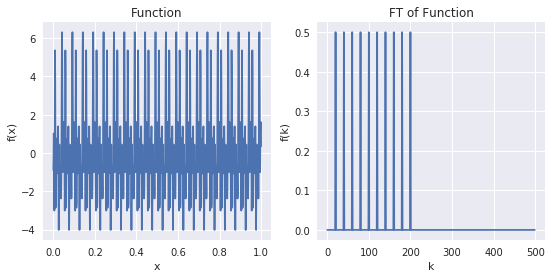

In [15]:
x, y = make_phased_waves(opt)
plot_wave_and_spectrum(opt, x, y)

Note that we only plot the positive frequencies, which is why the peaks in the spectrum are at $0.5$ (half the power is in the negative frequencies). Let's plot the manifold now: 

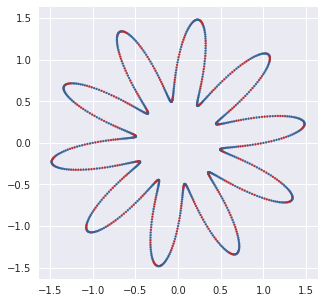

In [16]:
opt.L = 10    # <--- Controls the number of petals
plot_manifold(opt, binarize=True)

Observe how the parameter $L$ controls the number of petals in the curve. 

### Train the Model

In [12]:
def go(opt, repeats=10):
    all_frames = []
    for _ in range(repeats): 
        # Sample random phase
        opt.PHI = [np.random.rand() for _ in opt.K]
        # Generate data
        x, y = to_torch_dataset_2d(opt, *generate_dataset(opt))
        # Make model
        model = make_model(opt)
        # Train
        frames = train_model(opt, model, x, y)
        all_frames.append(frames)
        print('', end='\n')
    return all_frames

def go_once(opt): 
    # Sample random phase
    opt.PHI = [np.random.rand() for _ in opt.K]
    # Generate data
    x, y = to_torch_dataset_2d(opt, *generate_dataset(opt))
    # Make model
    model = make_model(opt)
    # Train
    frames = train_model(opt, model, x, y)
    # Done
    return model, frames

#### Regression on the Manifold

In [29]:
opt.L = 10   # <----- Change me! 
opt.CLASSIFICATION = False

In [30]:
frames = go(opt, 5)

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


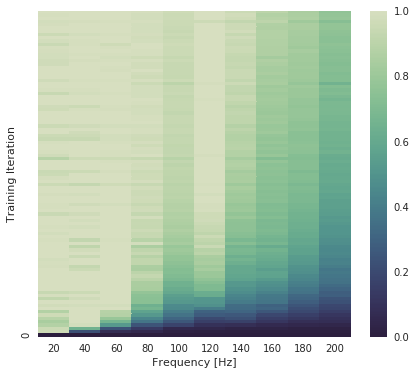

In [31]:
plot_spectral_dynamics(opt, frames)

The parameter $L$ above can be changed to run the same experiment on different manifolds. 

#### Plot Model Predictions

We now plot what the model does in higher dimensions. 

In [48]:
opt.L = 20
opt.CLASSIFICATION = True
opt.K = [200]
model, frames = go_once(opt)

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

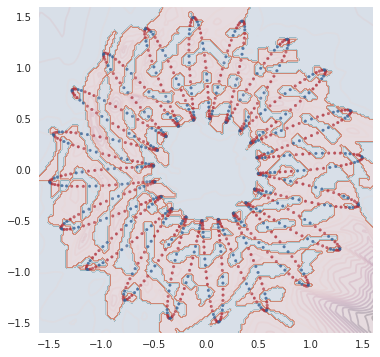

In [49]:
plot_model(opt, model)

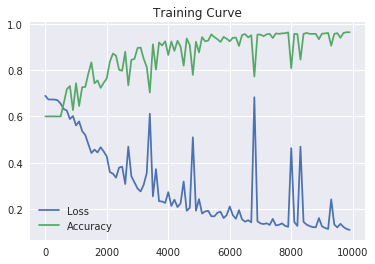

In [50]:
plot_history(frames)